# This notebook recreates plots in the results section of the paper

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 35,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [59]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age)*1e-9

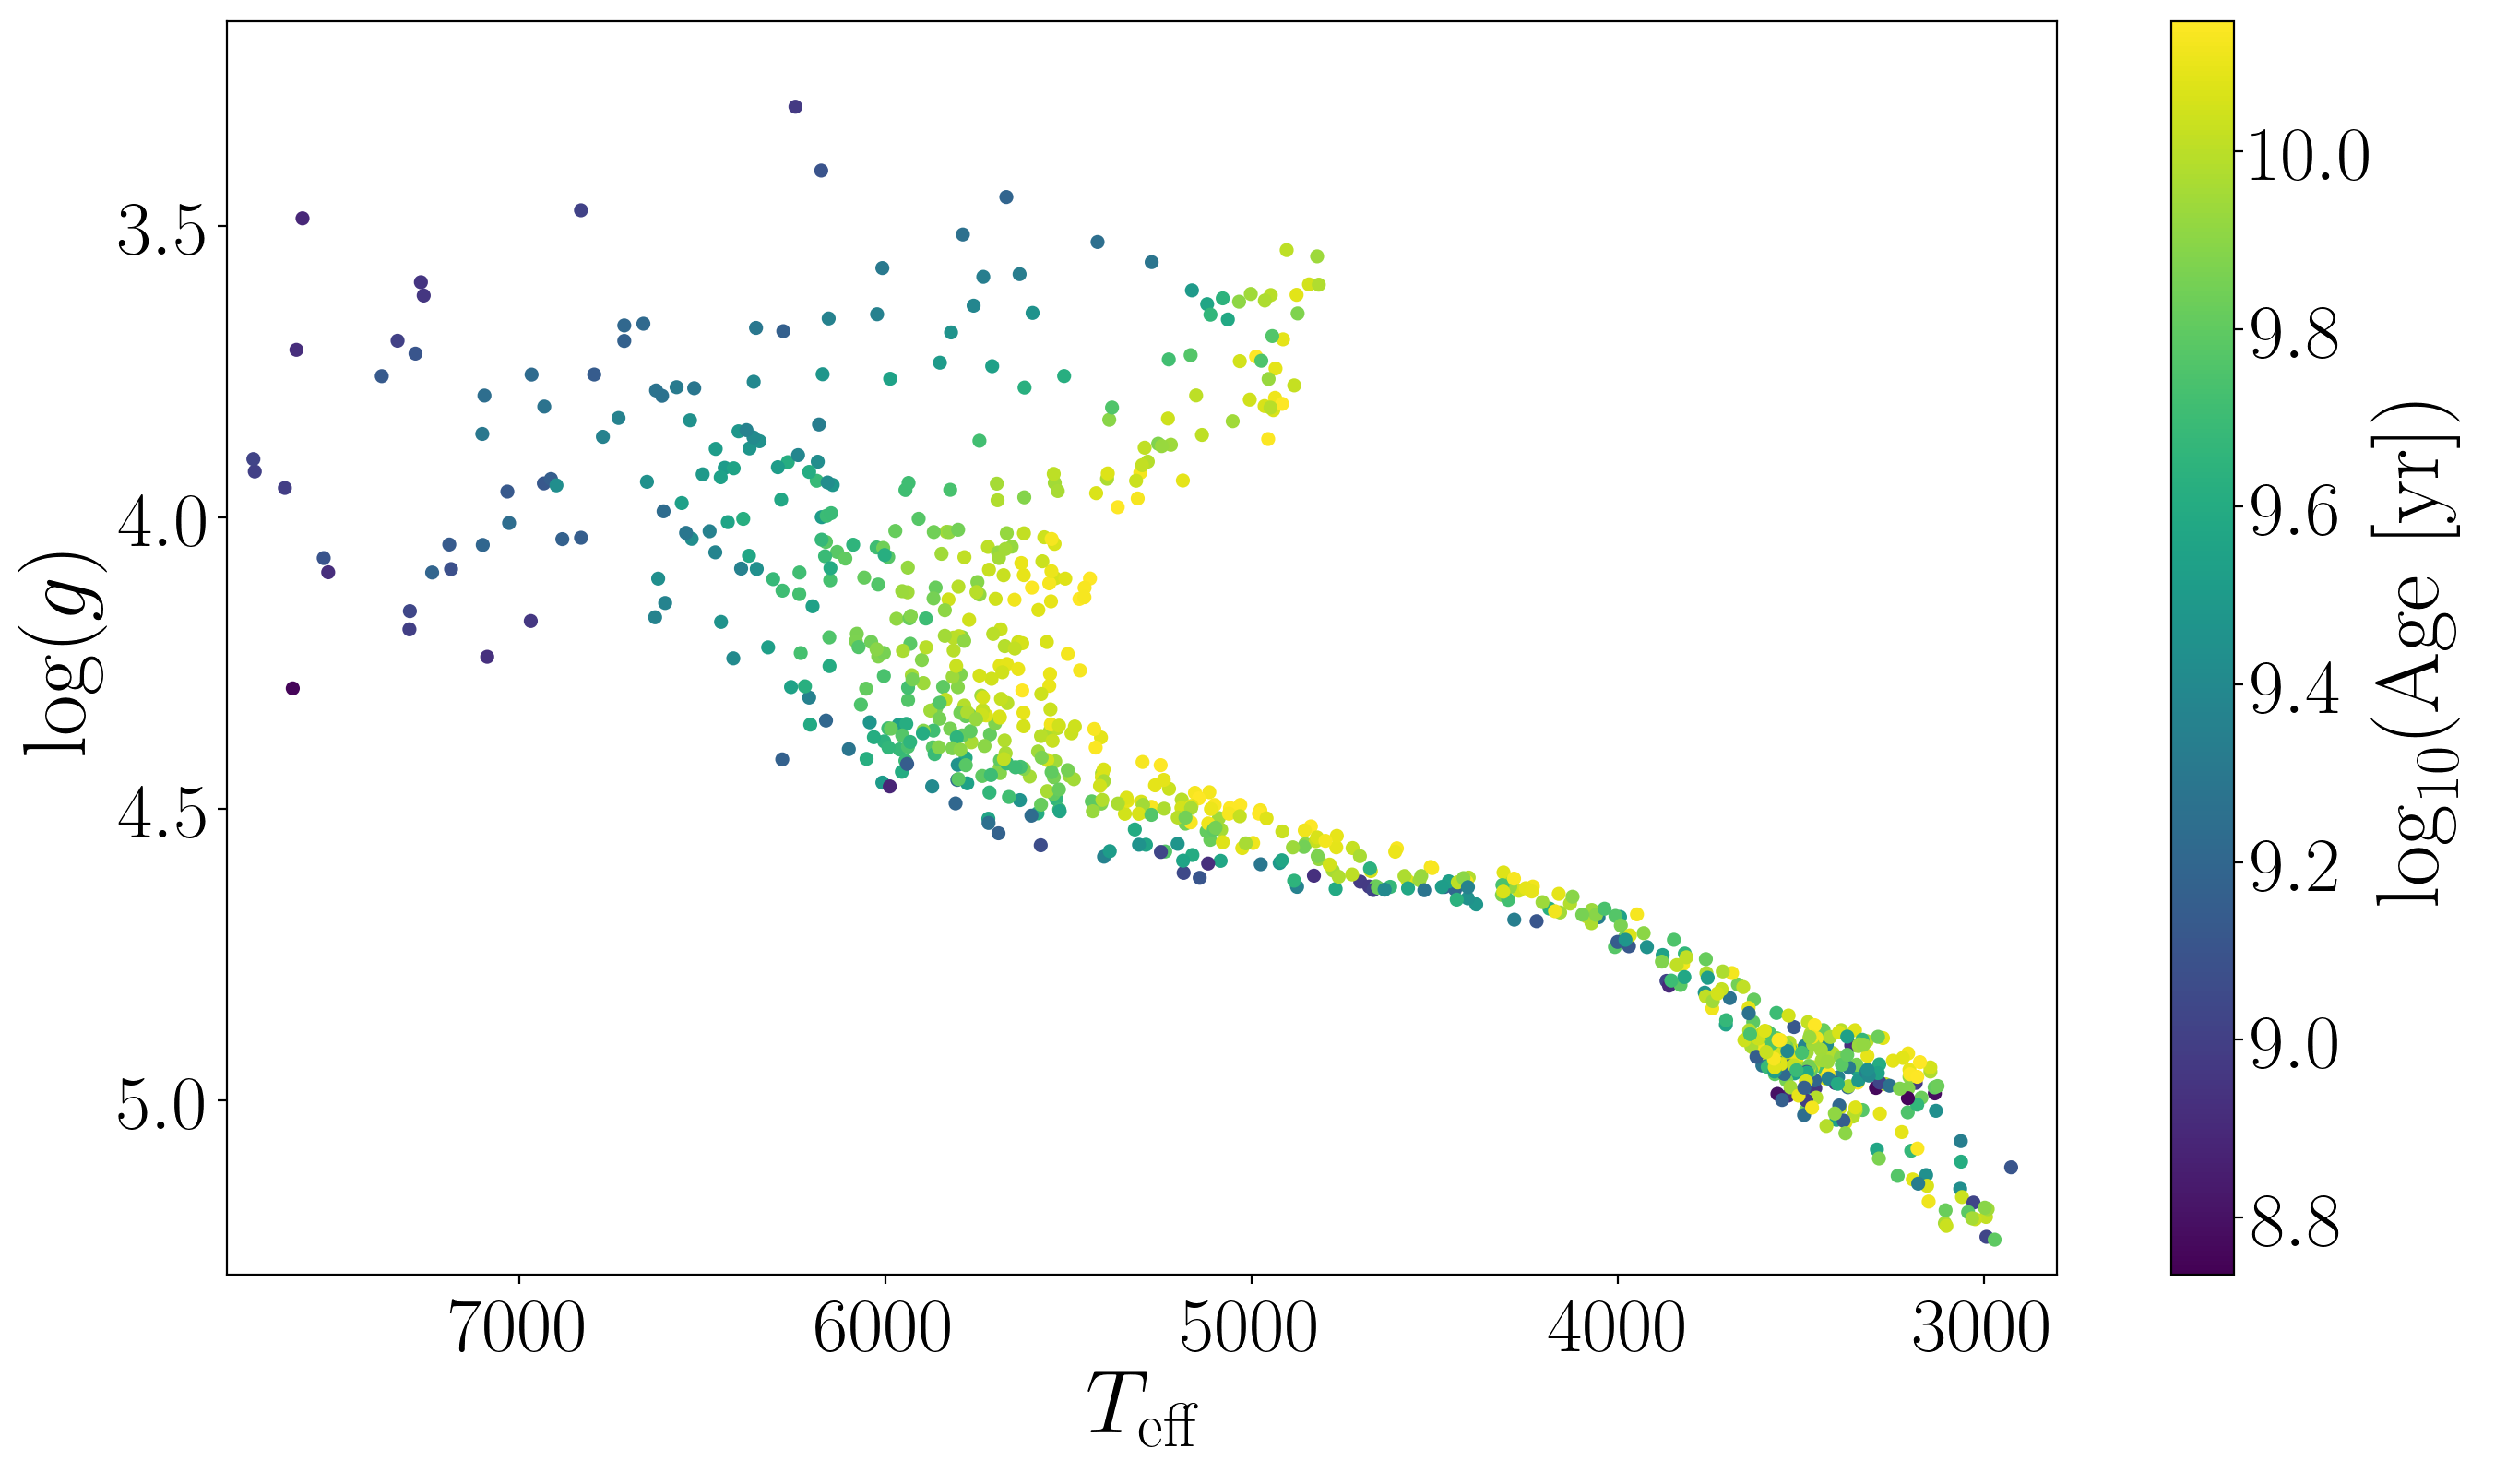

In [1105]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
# plt.xlim(5500, 3000)
# plt.ylim(5, 4.5)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("../simulated_CMD.pdf")

Plot a corner plot for the first star.

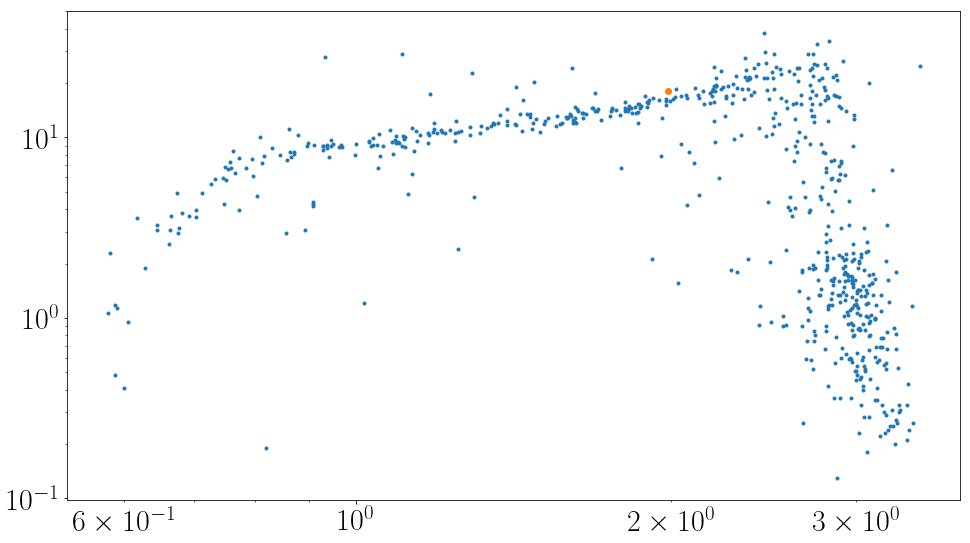

In [2]:
pr = pd.read_csv("data/praesepe.csv")
plt.figure(figsize=(16, 9))
plt.loglog(pr.bp - pr.rp, pr.prot, ".")
i = 4 #44
plt.loglog(pr.bp[i] - pr.rp[i], pr.prot[i], "o")

In [3]:
import stardate as sd
iso_params = {"G": (pr.G.values[i], .01),
              "BP": (pr.bp.values[i], .01),
              "RP": (pr.rp.values[i], .01),
              "parallax": (pr.parallax.values[i], pr.parallax_err.values[i]),
              "maxAV": .1}
print(iso_params)
print(pr["prot"][i])

fn = "{}_praesepe_test".format(str(int(pr.EPIC.values[i])).zfill(9))
star = sd.Star(iso_params, prot=pr.prot.values[i], prot_err=1., filename=fn)

inits = [330, np.log10(650*1e6), 0., np.log(177), 0.035]
sampler = star.fit(max_n=10000, inits=inits, optimize=True, model="praesepe")

{'G': (14.624638000000001, 0.01), 'BP': (15.622285, 0.01), 'RP': (13.635796, 0.01), 'parallax': (5.1566481048636525, 0.04285005106143857), 'maxAV': 0.1}
18.22


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 10000/10000 [01:22<00:00, 121.77it/s]


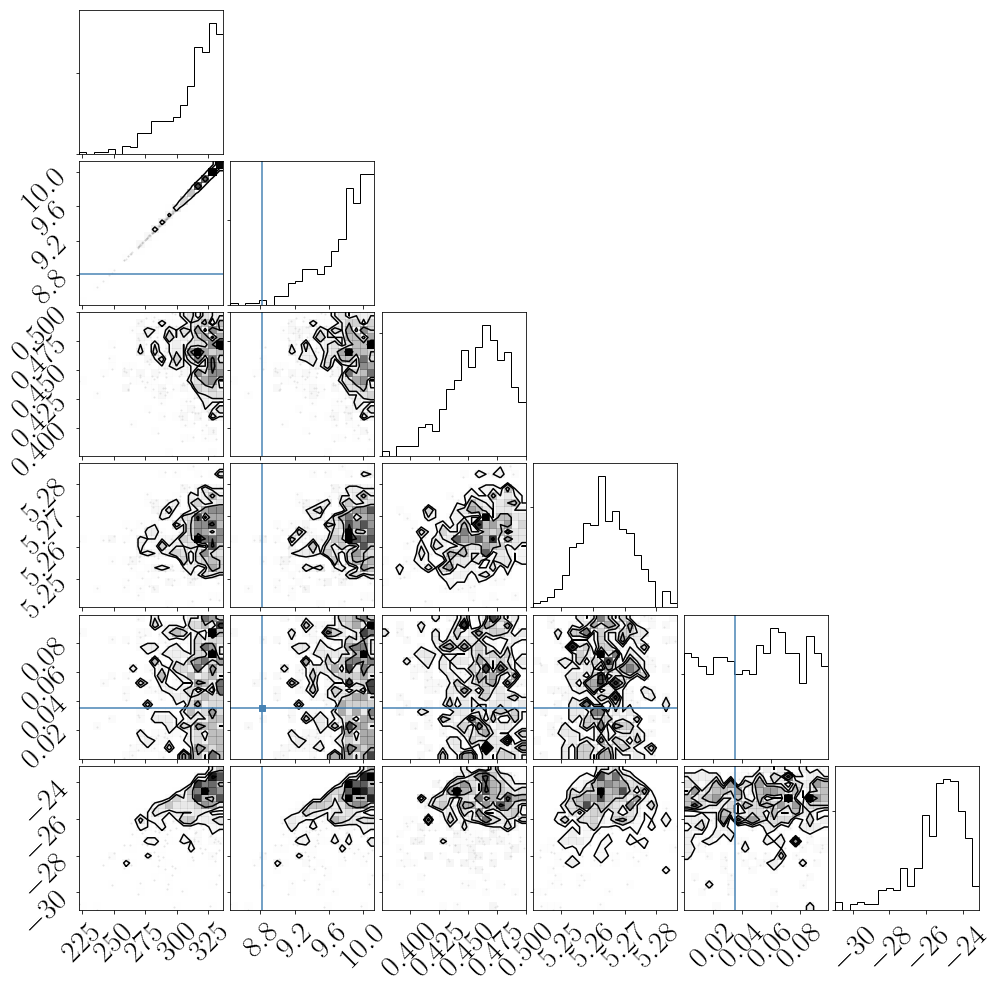

In [4]:
reader = emcee.backends.HDFBackend("{}.h5".format(fn), read_only=True)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
augmented = np.zeros((nsteps, nwalkers, ndim+1))
augmented[:, :, :-1] = samples
augmented[:, :, -1] = lnprobs
nsteps, nwalkers, ndim = np.shape(augmented)
    
burnin = 80
samps = np.reshape(augmented[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
tr = [None, np.log10(650*1e6), None, np.log(177), 0.035, None, None]
corner.corner(samps, truths=tr);

[217.53598495542147, 8.829764812870915, -0.05341041676945858, 1.7465616669169508, 0.09474459462602096]


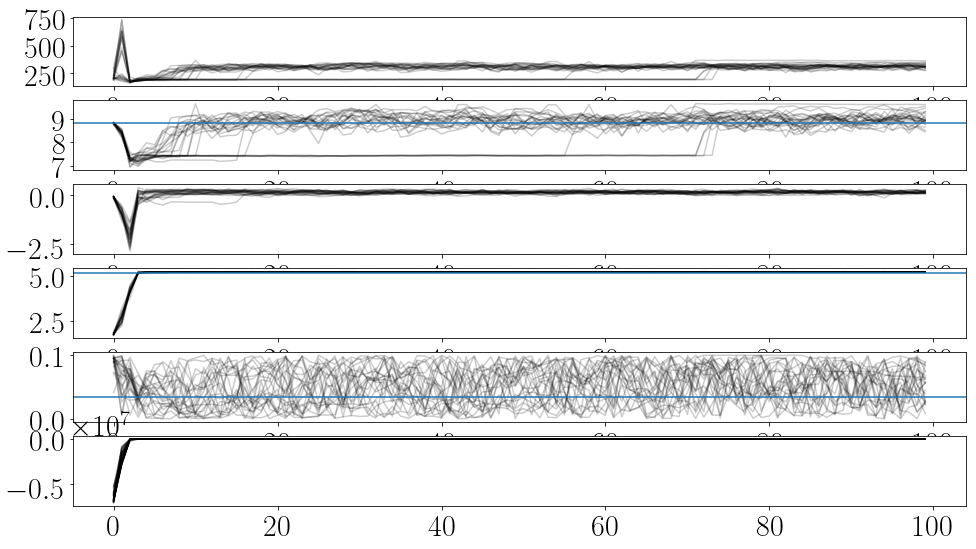

In [6]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    if tr[j]:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
print(inits)

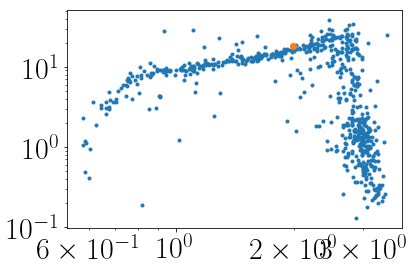

In [56]:
pr = pd.read_csv("data/praesepe.csv")
i = 4
plt.loglog(pr.bp - pr.rp, pr.prot, ".")
plt.loglog(pr.bp[i] - pr.rp[i], pr.prot[i], "o")

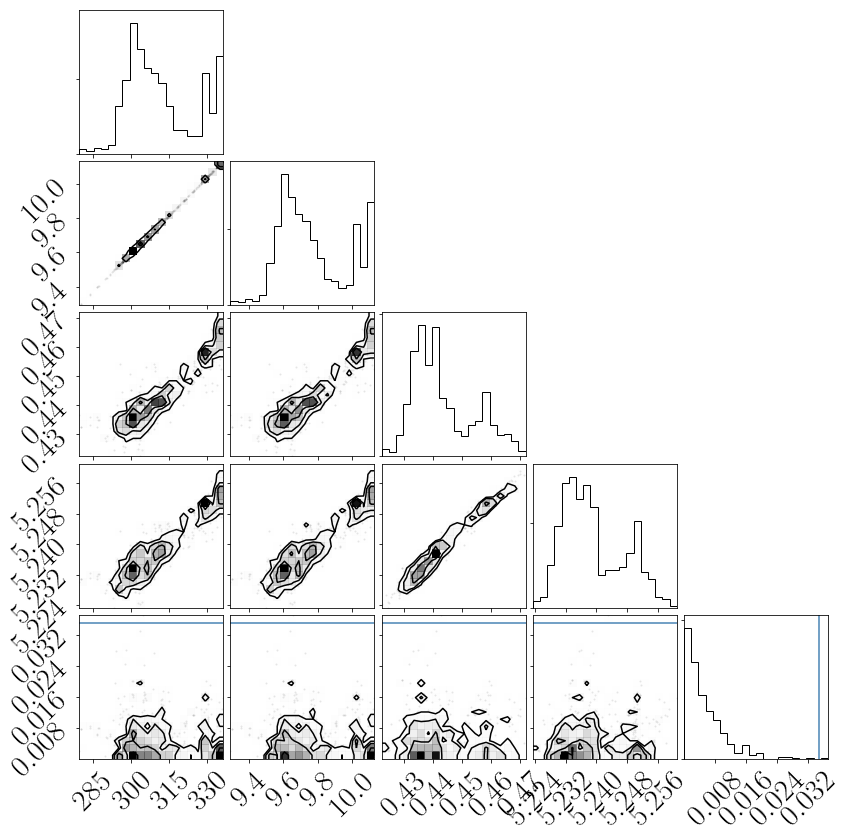

In [57]:
# print("true", list([df.eep[i], df.age[i], df.feh[i], np.log(df.d_kpc[i]), df.Av[i]]))

# fname = "{}_stardate.h5".format(str(i).zfill(4))
fname = "praesepe_results/{}_praesepe_stardate.h5".format(str(pr.EPIC.values[i]).zfill(9))

reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
# augmented = np.zeros((nsteps, nwalkers, ndim+1))
# augmented[:, :, :-1] = samples
# augmented[:, :, -1] = lnprobs
# nsteps, nwalkers, ndim = np.shape(augmented)
    
burnin = 100
samps = np.reshape(samples[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
# tr = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)), df.Av.values[i], None]
tr = [None, np.log10(650*1e6), None, np.log(177), 0.035, None]
corner.corner(samps, truths=tr);

### And plot the trace.

[186.1051805835191, 8.834170840034574, 0.004446847933067077, 1.6566618384417549, 0.06915310890273486]


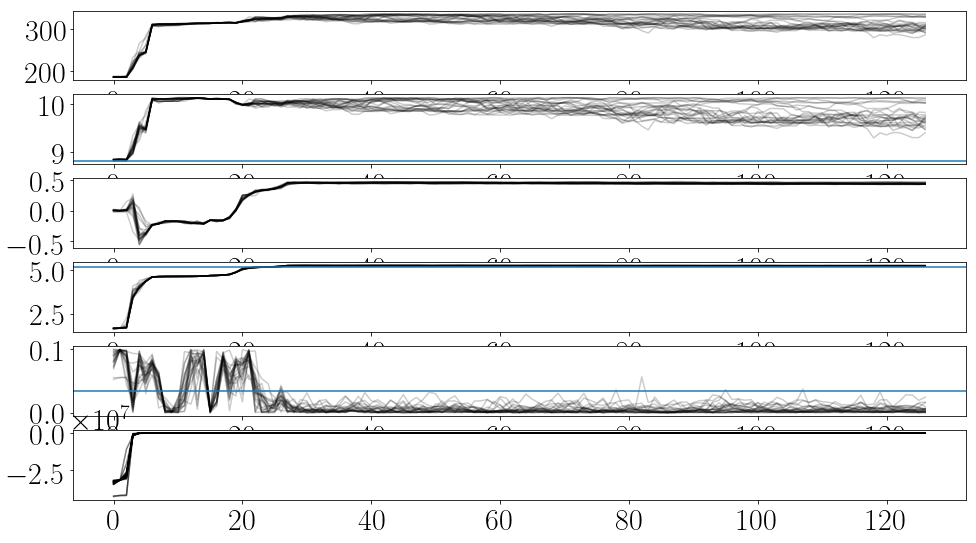

In [58]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    if tr[j]:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
print(inits)

Now plot all the results.

In [10]:
def percentiles_from_samps(samps):
    med = np.median(samps)
    std = np.std(samps)
    upper = np.percentile(samps, 84)
    lower = np.percentile(samps, 16)
    errp = upper - med
    errm = med -lower
    return med, errp, errm, std


def read_files(name, ids, dirname=".", burnin=100):
    meds, age_samps, errp, errm, std, inds = [], [], [], [], [], []
    
    for i, ID in enumerate(ids):
        try:
            fname = "{0}/{1}_{2}.h5".format(dirname, str(int(ID)).zfill(4), name)
            reader = emcee.backends.HDFBackend(fname)
            samples = reader.get_chain()
            
            if np.shape(samples)[0] > 10:
                nsteps, nwalkers, ndim = np.shape(samples)
                samps = np.reshape(samples, (nsteps*nwalkers, ndim))
            
                a, ap, am, _std = percentiles_from_samps((10**samps[burnin:, 1])*1e-9)
                age_samps.append((10**samps[burnin:, 1])*1e-9)
                meds.append(a)
                errp.append(ap)
                errm.append(am)
                std.append(_std)
                inds.append(i)
                    
        except:
            pass
    
    return age_samps, np.array(meds), np.array(errp), np.array(errm), np.array(std), np.array(inds)

age_samps, meds, errp, errm, std, inds = read_files("stardate", np.arange(1000))
print(len(inds))

734


Select stars of different types.

In [942]:
def selection(df, inds):

    hot_cut, cool_cut, giant_cut, ro_cut = .45, 1.35, 440, 1.8
    Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
    evolved = (df.eep.values[inds] > giant_cut) #* (df.BV.values[inds] > hot_cut)
    hot = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] < giant_cut)
    hot_evolved = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] > giant_cut)
    cool = (df.BV.values[inds] > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
    fgk = (df.eep.values[inds] < giant_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
            * (Ro < ro_cut)
    rossbied = (Ro > ro_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
        * (df.eep.values[inds] < giant_cut)
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds)

Plot the empirical precision on the HR diagram (use log g to spread out the main sequence better).

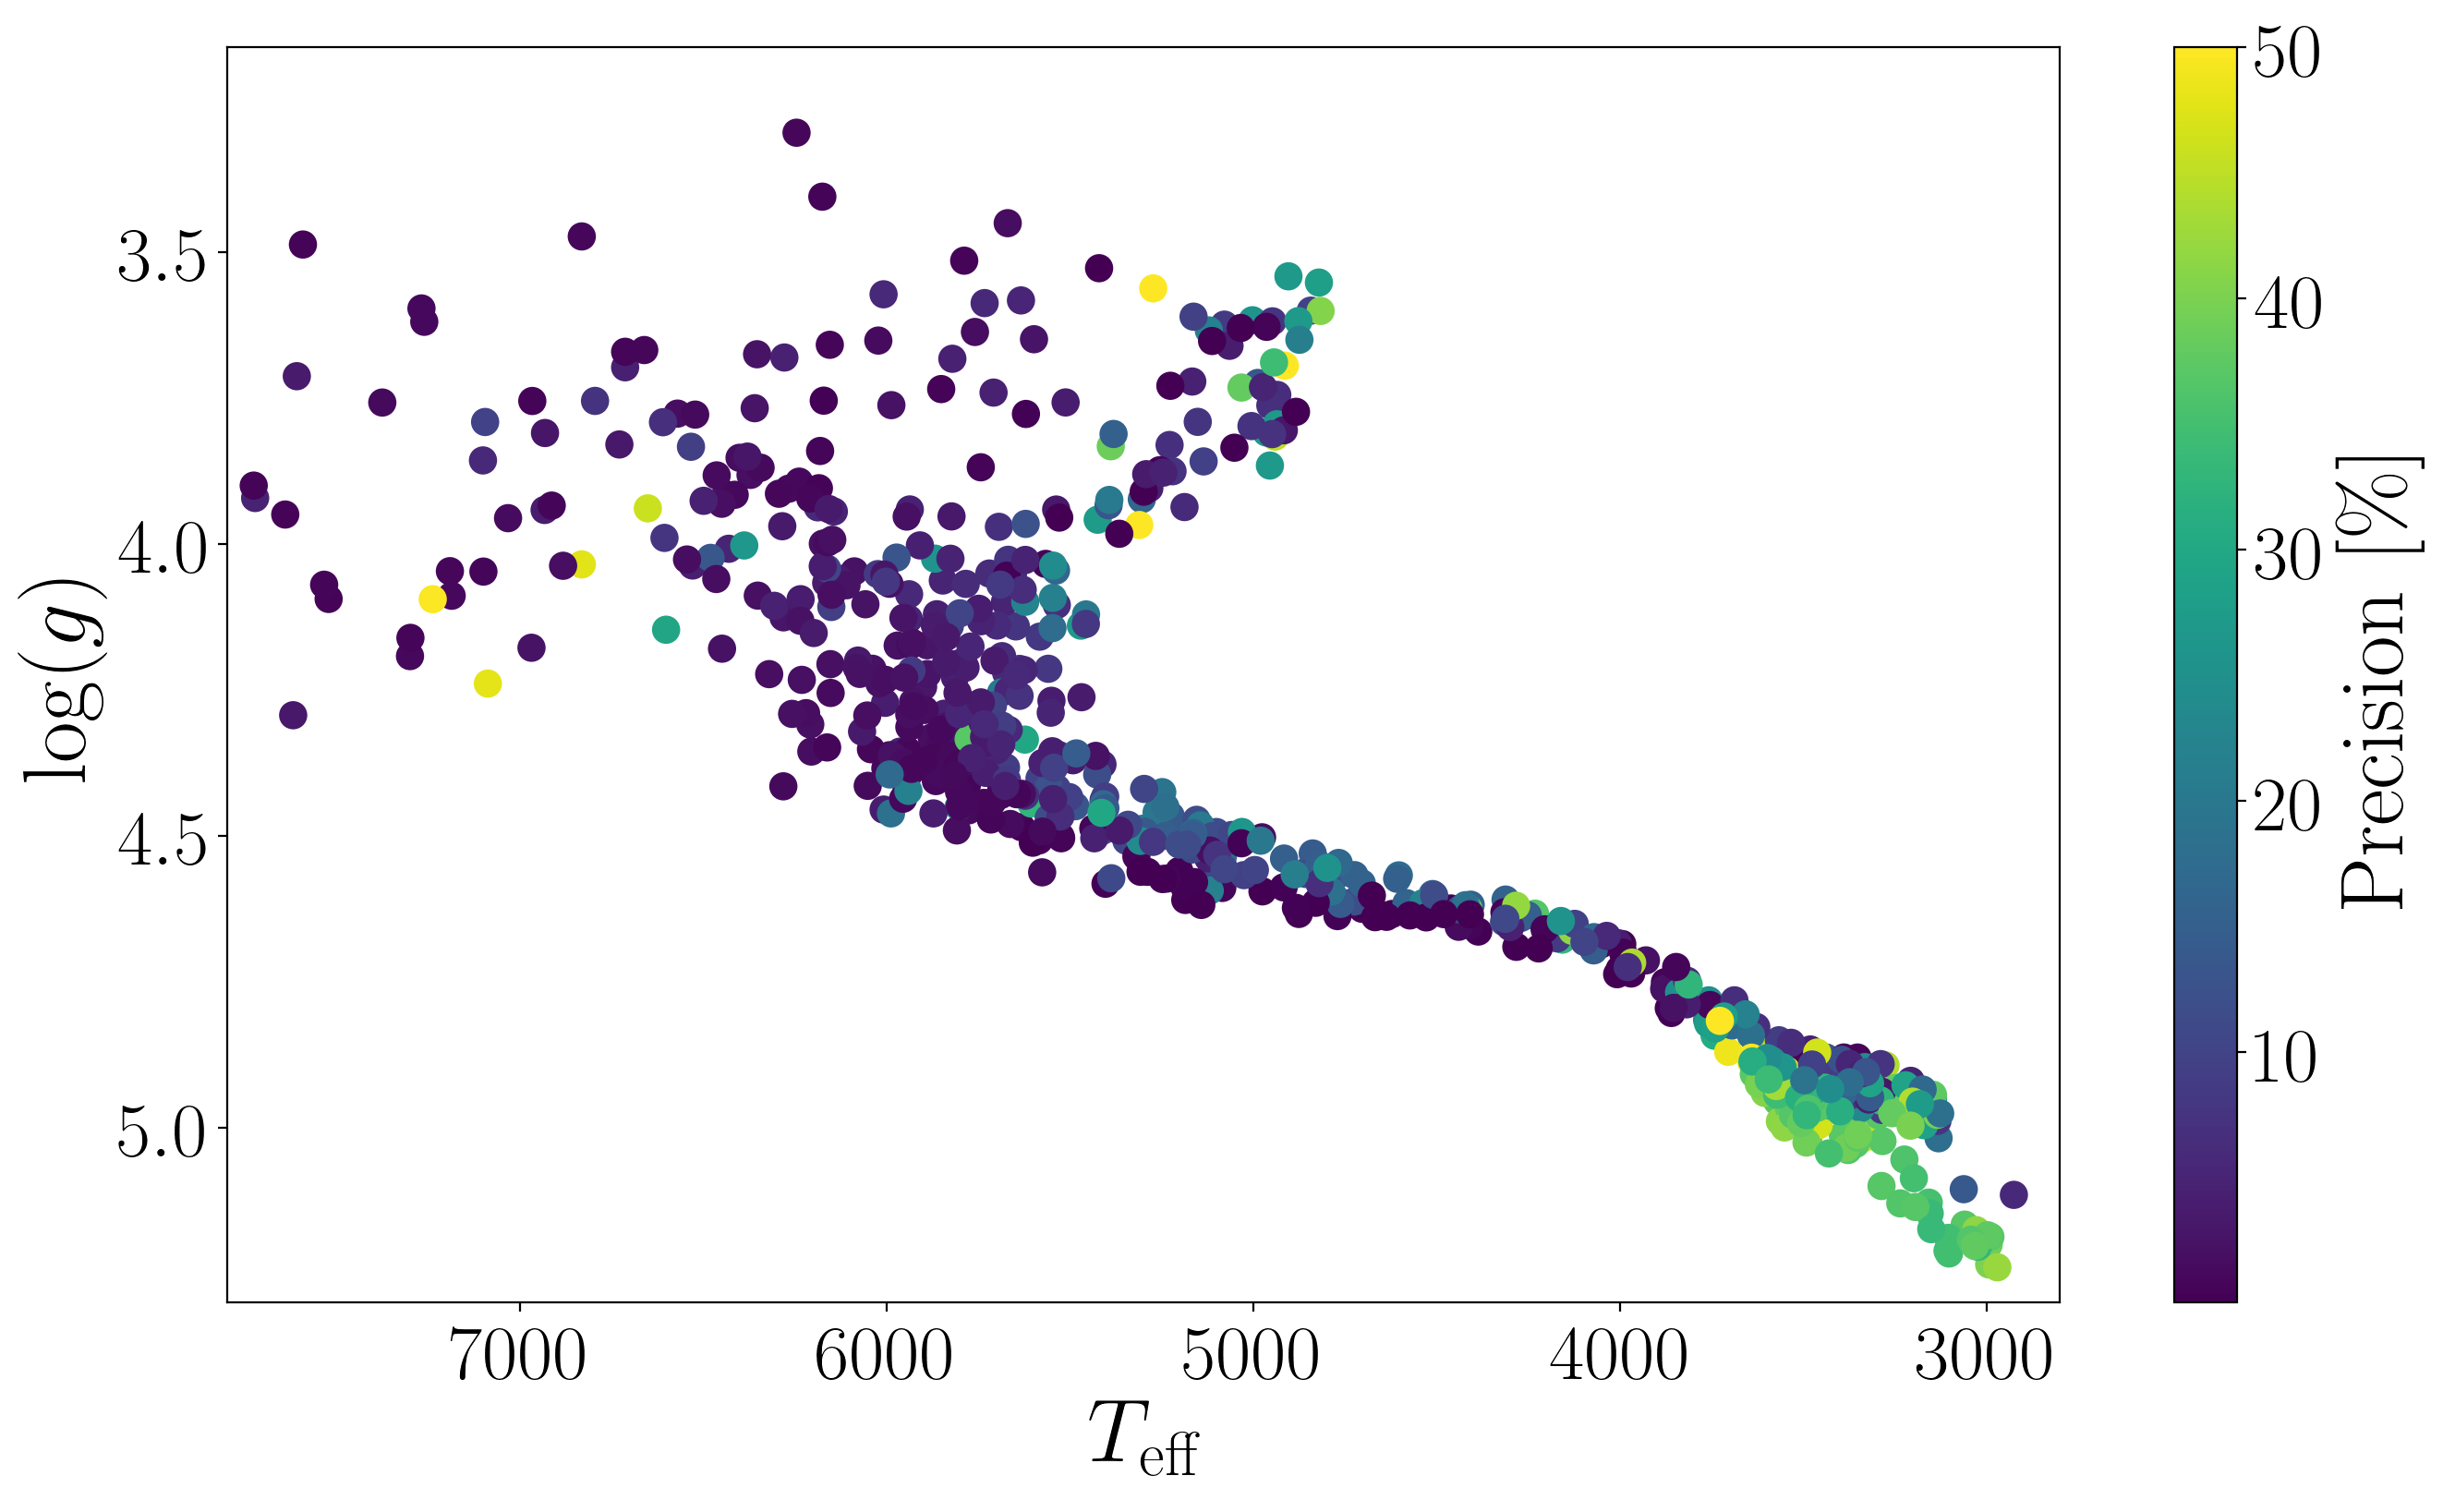

In [1102]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=(stds/df.age.values[inds])*100, s=100, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("precision_plot")
plt.savefig("../precision_plot.pdf")

Error plot (accuracy)

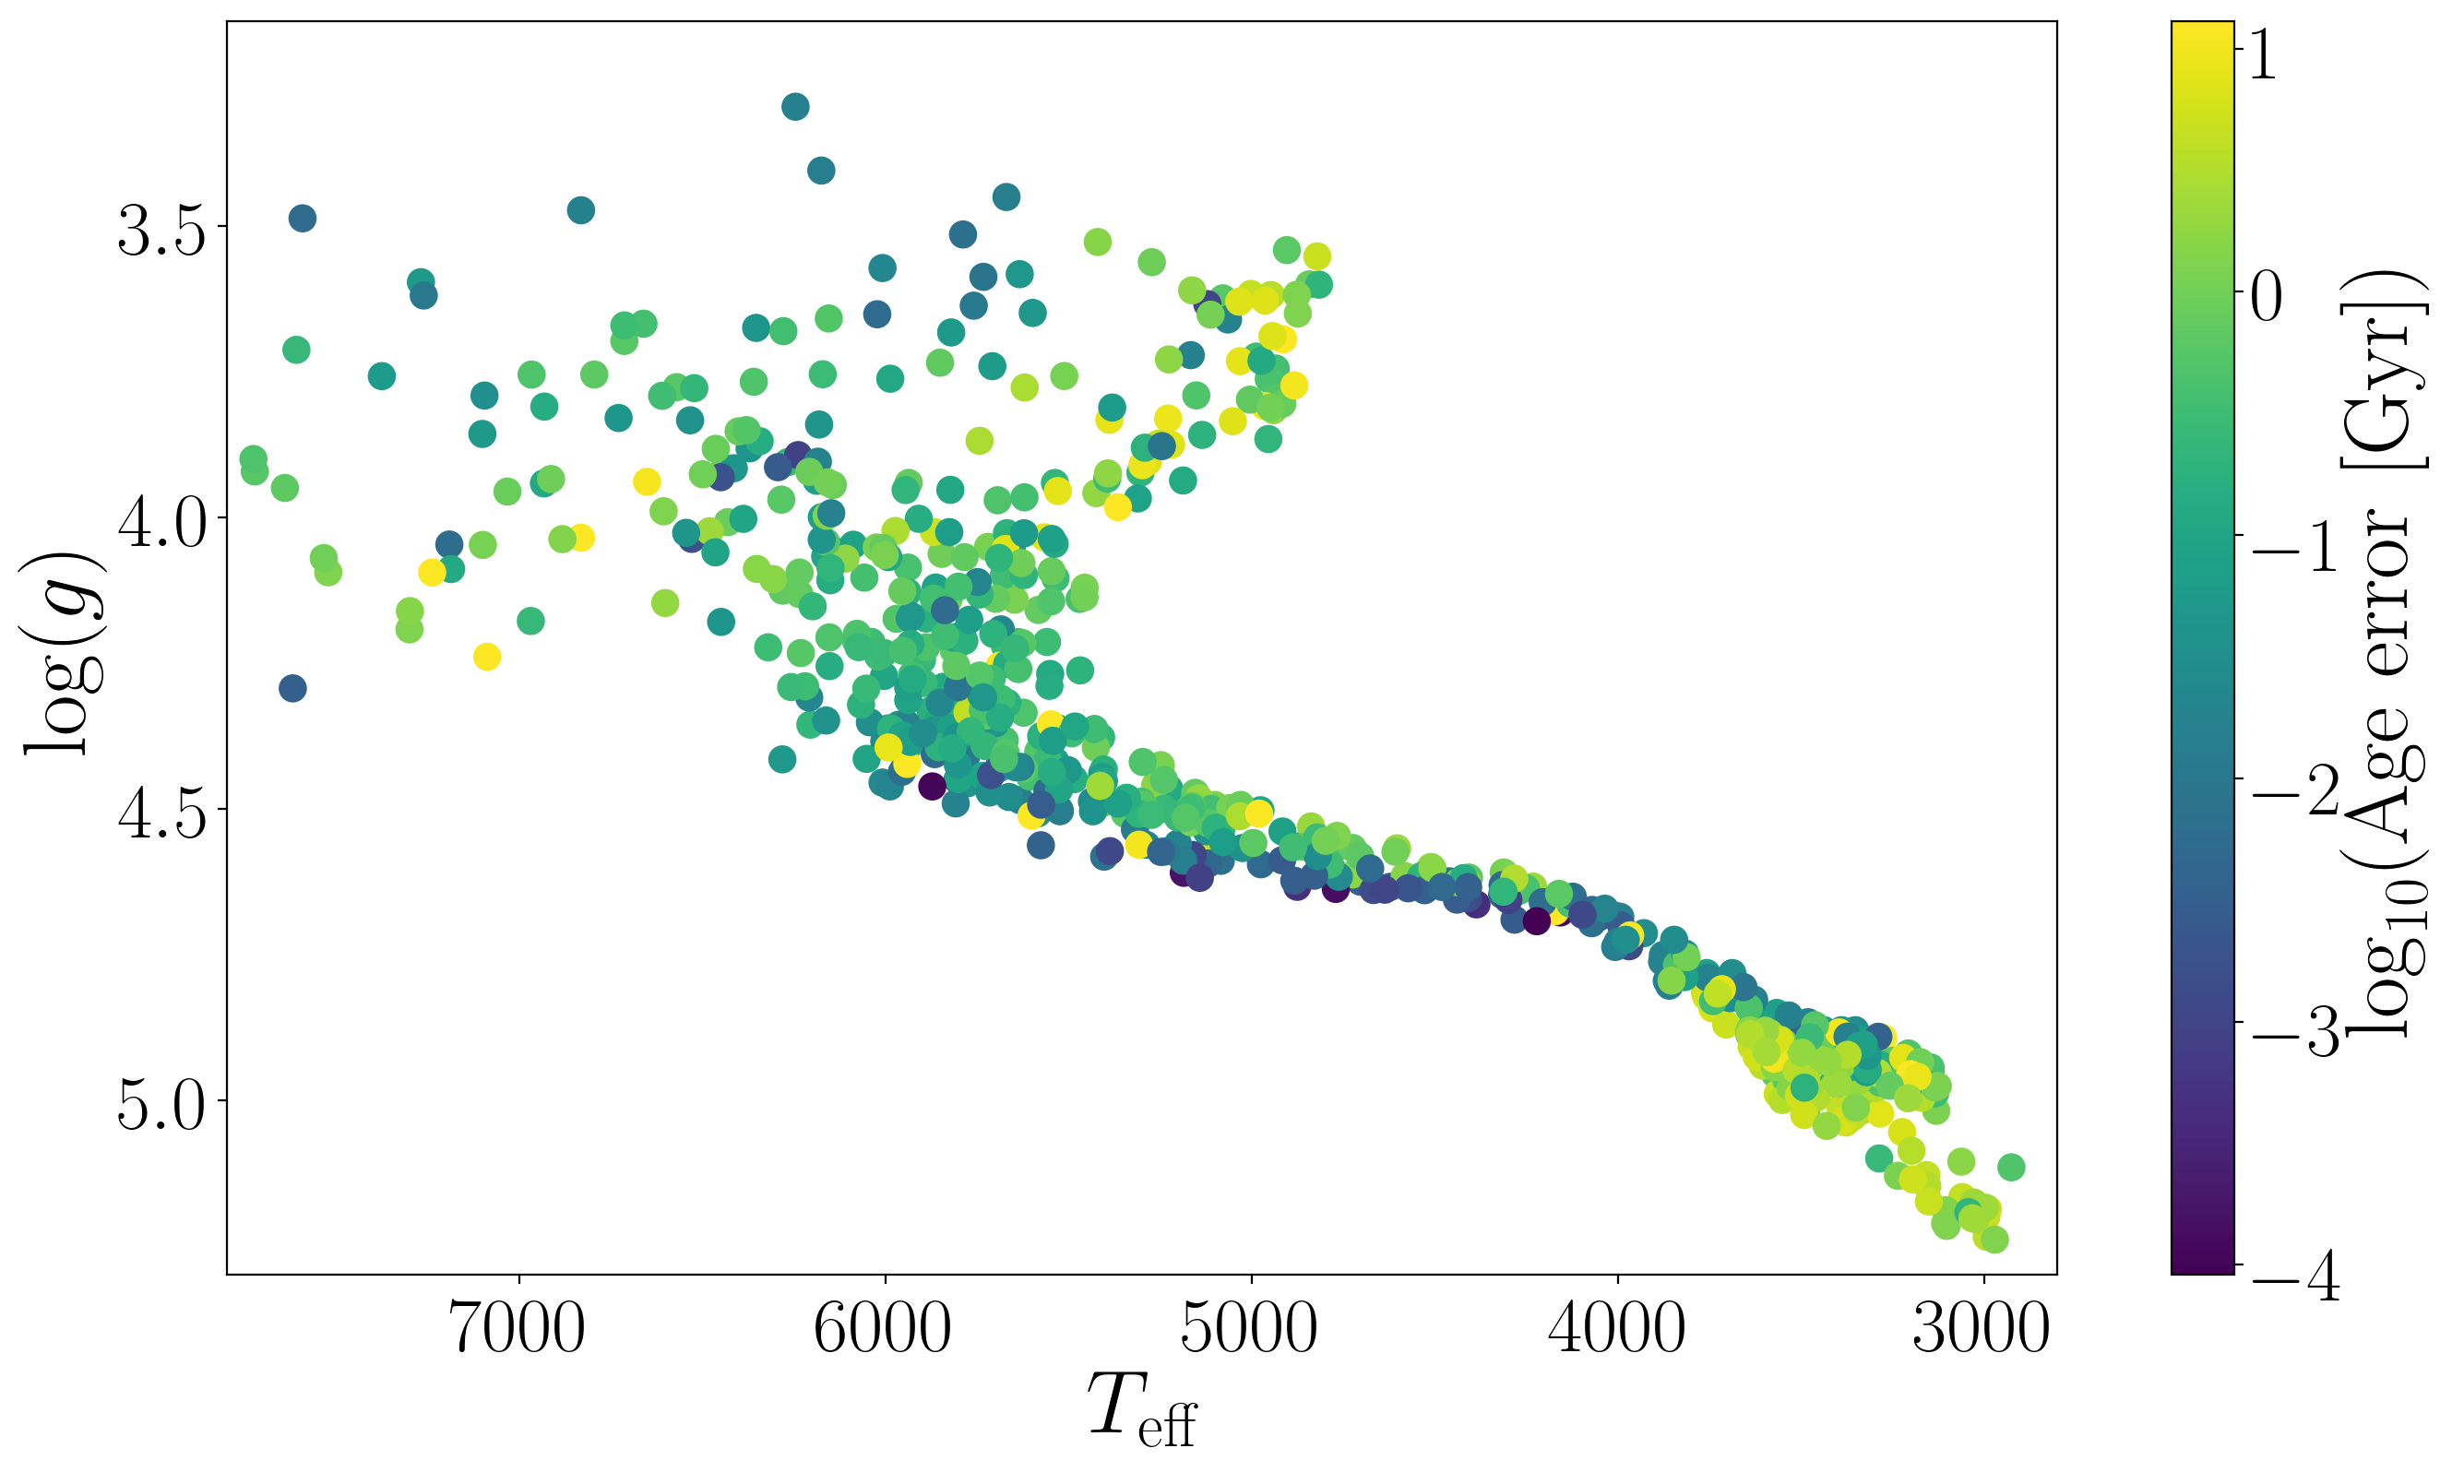

In [1103]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=np.log10(abs(true_age_gyr[inds] - meds)), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Age~error~[Gyr])}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("error_plot")
plt.savefig("../error_plot.pdf")

Text(0, 0.5, '$\\log(g)$')

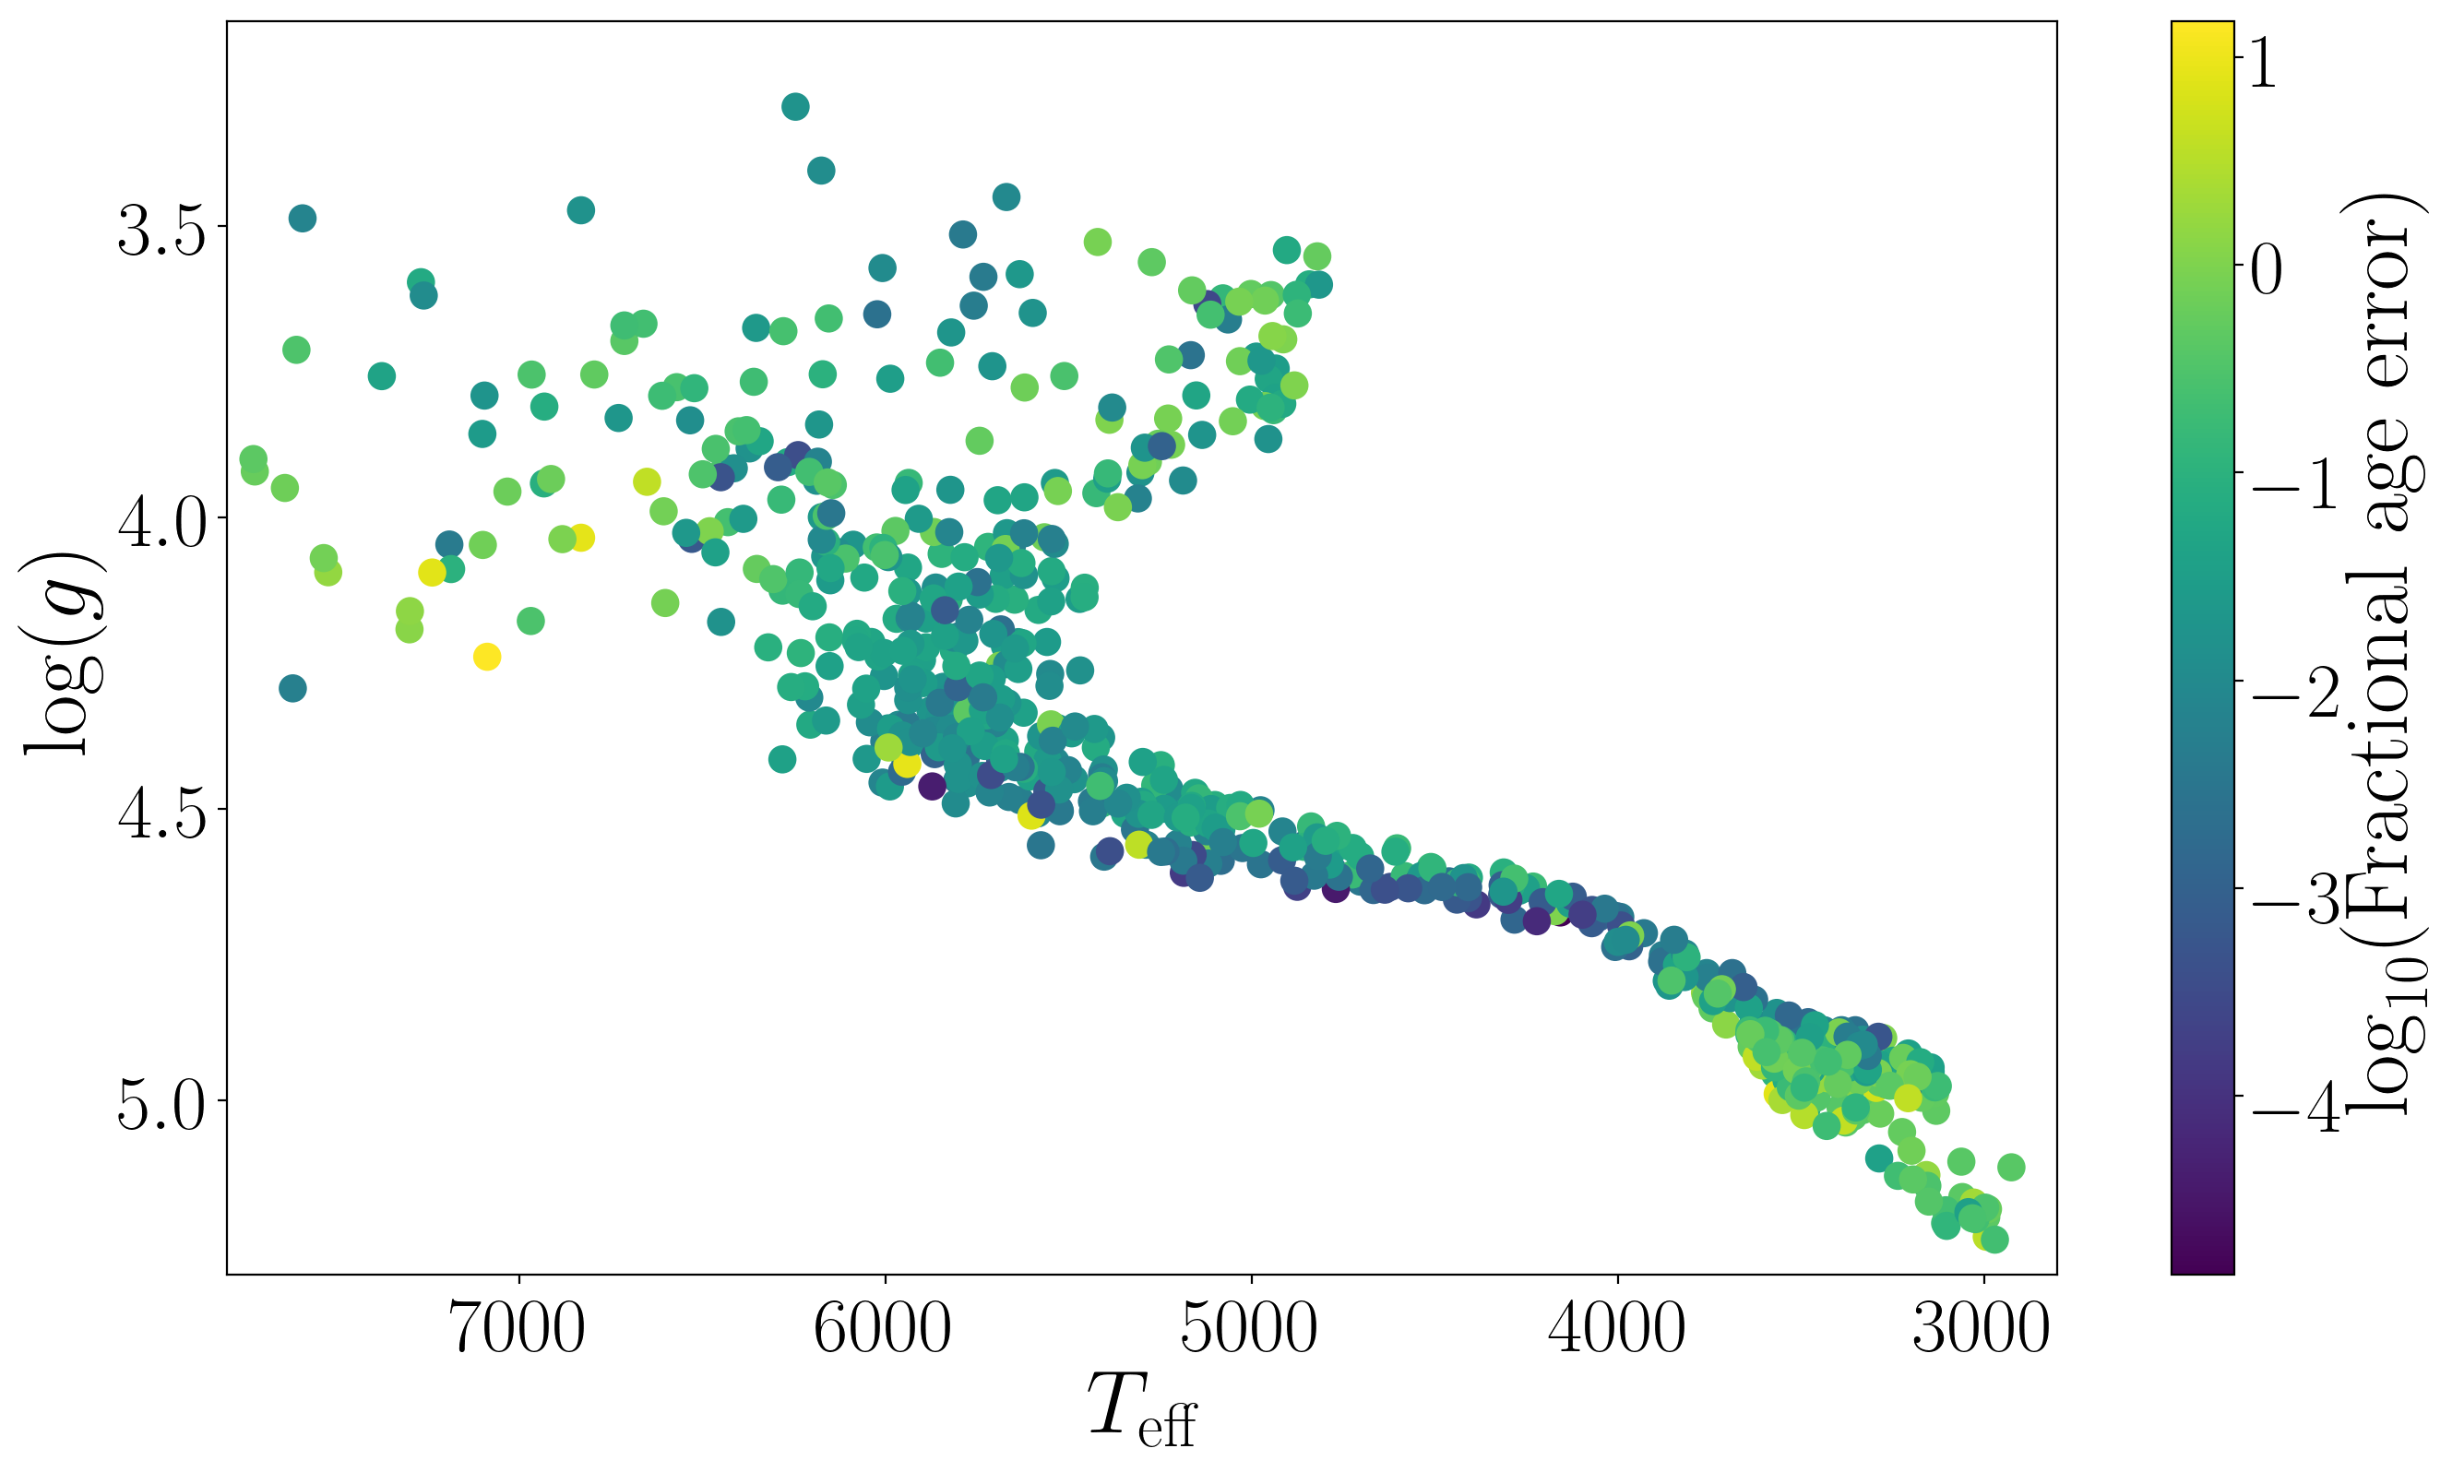

In [1104]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=np.log10(abs(true_age_gyr[inds] - meds)/true_age_gyr[inds]), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Fractional~age~error)}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the isochrone model.

In [935]:
imeds, istds, iage_samps, iresids, ierrp, ierrm = [], [], [], [], [], []
ieeps, ieep_errp, eiep_errm, iinds = [], [], [], []
iavs, iav_errp, iav_errm = [], [], []

burnin = 1

for i in range(N):
    try:
        fname = "{0}_isochrones.h5".format(str(i).zfill(4))
        reader = emcee.backends.HDFBackend(fname)
        samples = reader.get_chain()
        nsteps, nwalkers, ndim = np.shape(samples)
        samps = np.reshape(samples, (nsteps*nwalkers, ndim))

        lin_samps = (10**samps[burnin:, 1])*1e-9
        iage_samps.append(lin_samps)
        imeds.append(np.median(lin_samps))
        istds.append(np.std(lin_samps))
        upper = np.percentile(lin_samps, 84)
        lower = np.percentile(lin_samps, 16)
        ierrp.append(upper-np.median(lin_samps))
        ierrm.append(np.median(lin_samps)-lower)
    
        ieep_samps = samps[burnin:, 0]
        ieeps.append(np.median(ieep_samps))
        upper = np.percentile(ieep_samps, 84)
        lower = np.percentile(ieep_samps, 16)
        ieep_errp.append(upper-np.median(ieep_samps))
        ieep_errm.append(np.median(ieep_samps)-lower)
        
        iav_samps = samps[burnin:, 4]
        iavs.append(np.median(iav_samps))
        upper = np.percentile(iav_samps, 84)
        lower = np.percentile(iav_samps, 16)
        iav_errp.append(upper-np.median(iav_samps))
        iav_errm.append(np.median(iav_samps)-lower)
        
        iinds.append(i)
        
    except AttributeError:
        pass

In [936]:
imeds, istds, ierrp, ierrm = np.array(imeds), np.array(istds), np.array(ierrp), np.array(ierrm)
print(len(iinds))

265


In [1018]:
iage_samps, imeds, ierrp, ierrm, istd, iinds = read_files("isochrones", np.arange(1000))

In [1020]:
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)

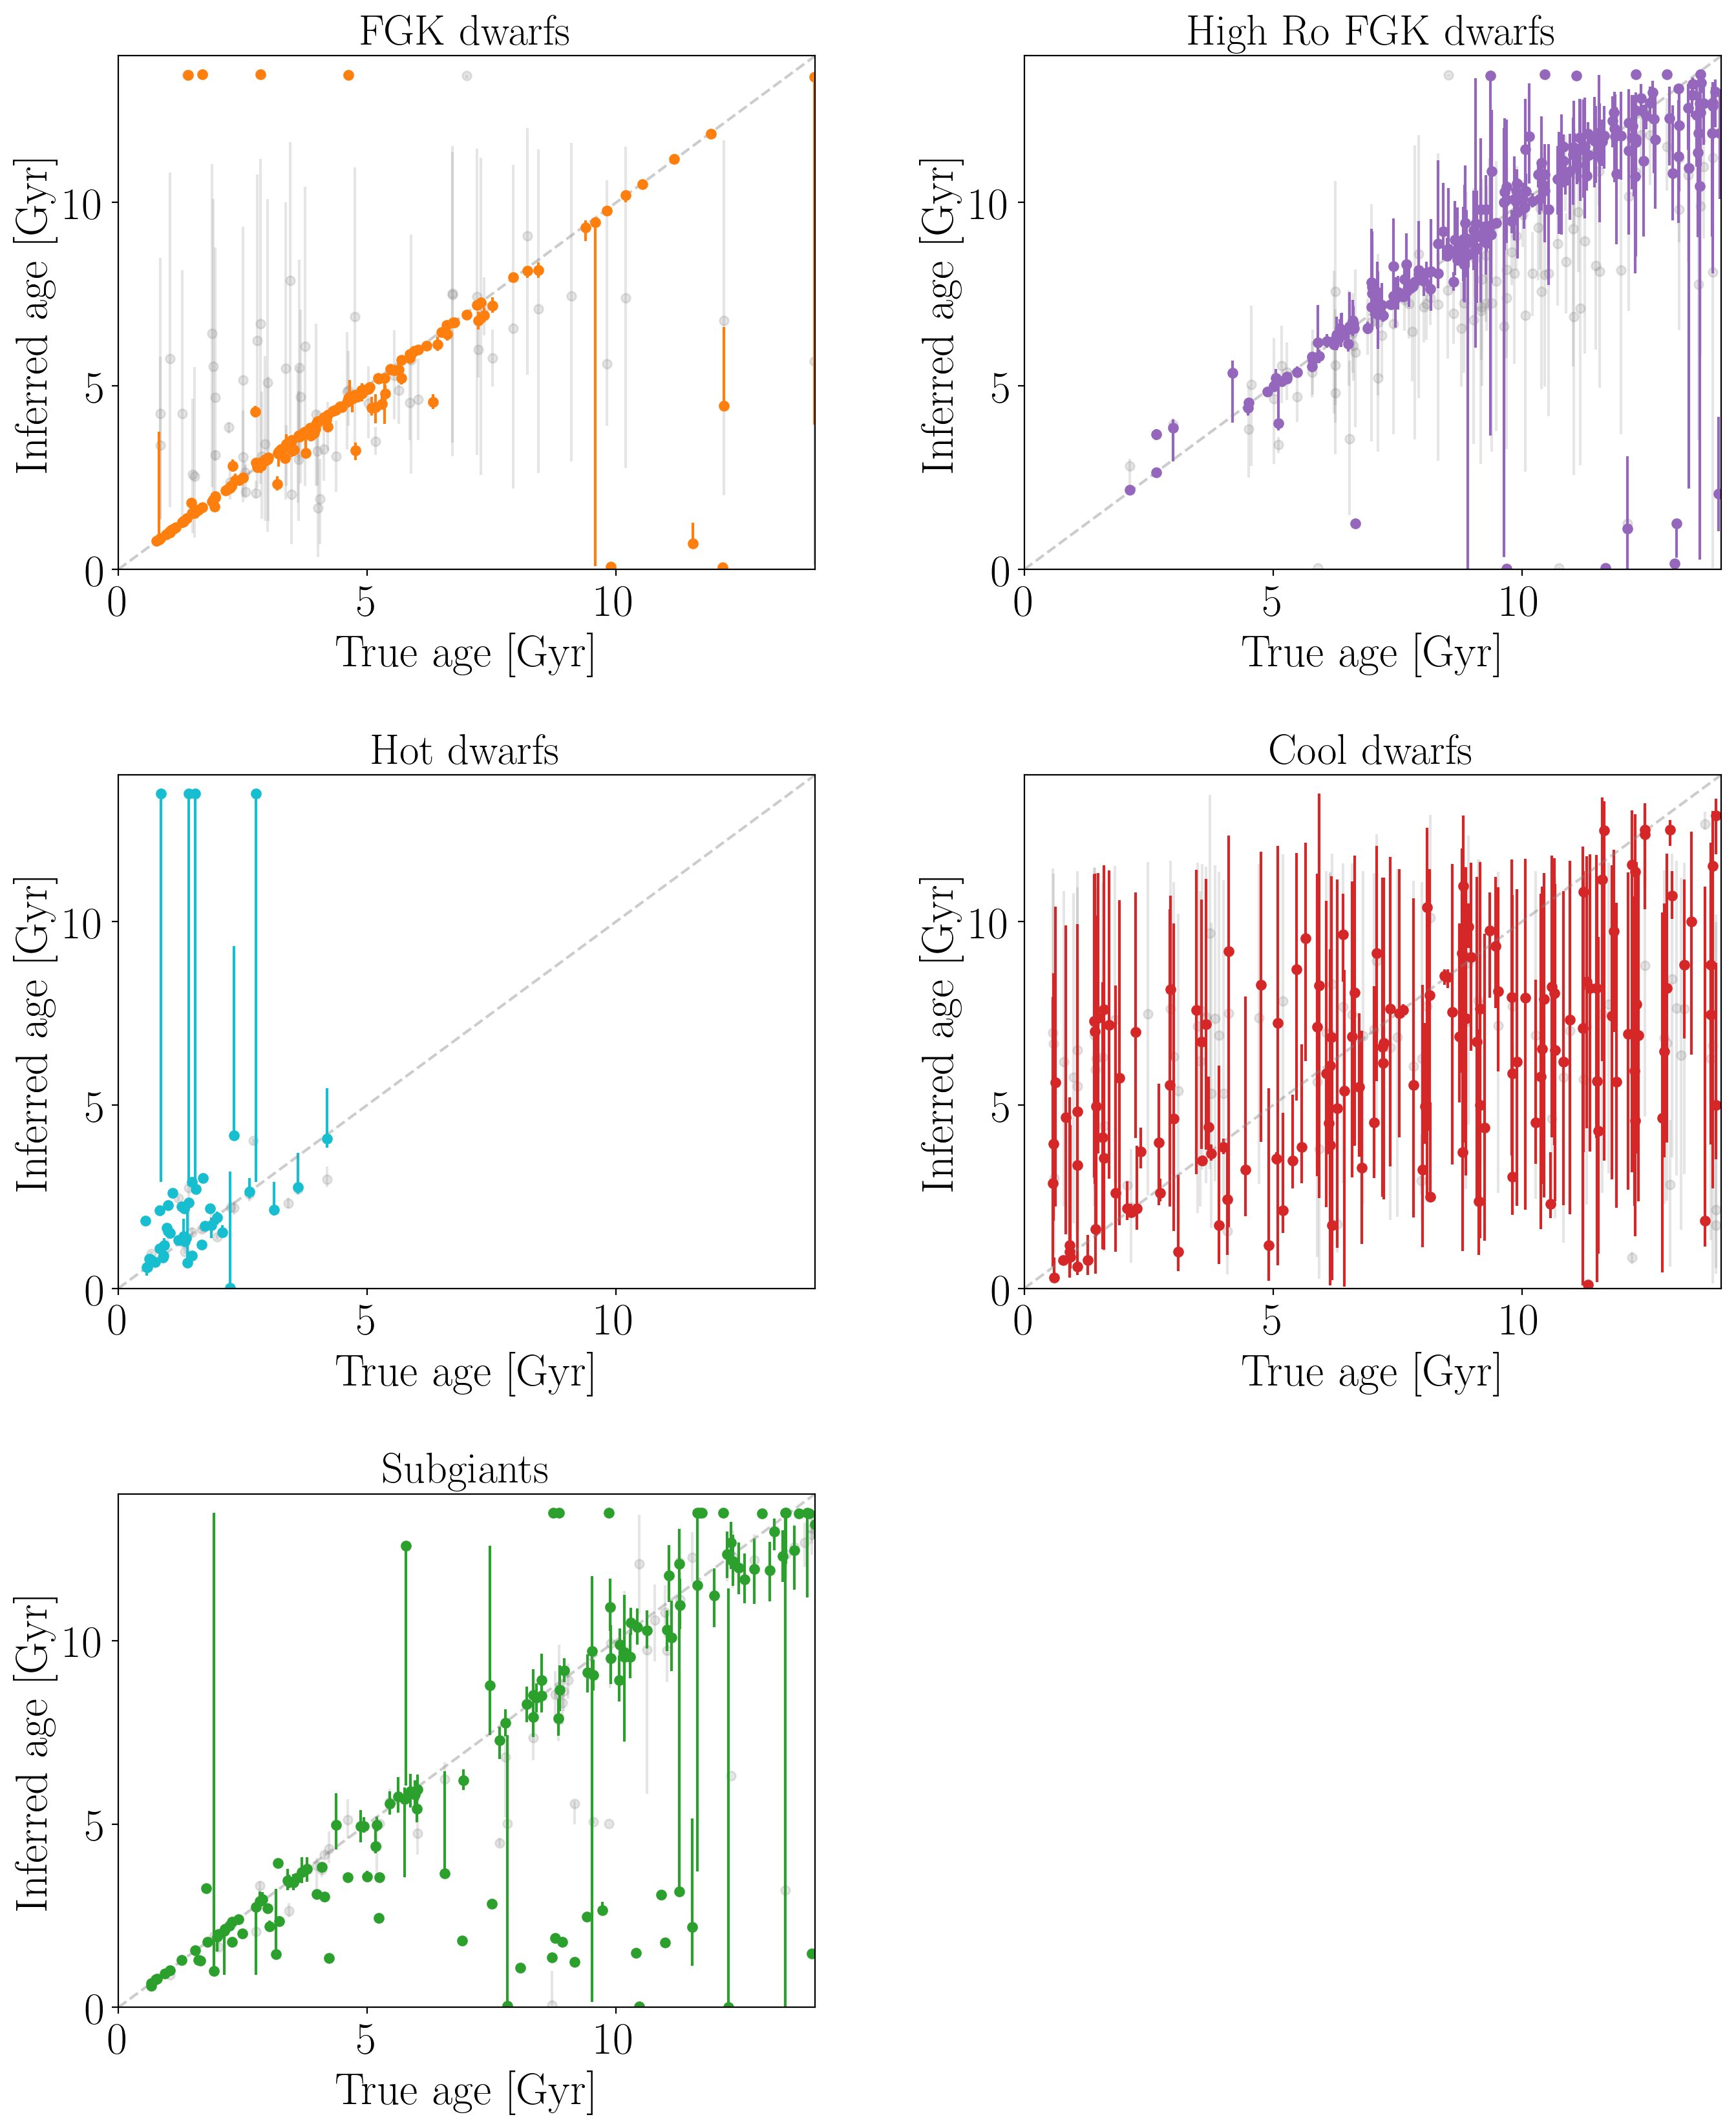

In [1106]:
plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 12,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 20), dpi=200)
plt.subplot(3, 2, 1)

plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs}$")

plt.subplot(3, 2, 2)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{High~Ro~FGK~dwarfs}$")

plt.subplot(3, 2, 3)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(3, 2, 4)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(3, 2, 5)
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.3, hspace=.4)
plt.savefig("../simulation_results.pdf")
plt.savefig("simulation_results")

Calculate precision for stardate.

In [1032]:
def precision(stds, meds):
    return np.median(stds/meds)*100

def accuracy(true, meds):
    return np.median(abs(meds - true))*1e3

def rel_acc(true, meds):
    return np.median((abs(meds - true)/meds)*100)

print("median FGK age precision = {:.2f} %".format(precision(std[fgk], meds[fgk])))
print("median FGK absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][fgk], meds[fgk])))
print("median FGK relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][fgk], meds[fgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(std[rossbied], meds[rossbied])))
print("median high Ro absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))
print("median high Ro relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(std[hot], meds[hot])))
print("median hot absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][hot], meds[hot])))
print("median hot relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][hot], meds[hot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(std[cool], meds[cool])))
print("median cool absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][cool], meds[cool])))
print("median cool relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][cool], meds[cool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(std[evolved], meds[evolved])))
print("median subgiant absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))
print("median subgiant relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))

median FGK age precision = 3.25 %
median FGK absolute age error = 27.25 Myr
median FGK relative age error = 0.73 %

median high Ro age precision = 8.49 %
median high Ro absolute age error = 248.26 Myr
median high Ro relative age error = 2.56 %

median hot age precision = 14.96 %
median hot absolute age error = 563.48 Myr
median hot relative age error = 36.36 %

median cool age precision = 50.11 %
median cool absolute age error = 2297.56 Myr
median cool relative age error = 40.53 %

median subgiant age precision = 7.60 %
median subgiant absolute age error = 468.66 Myr
median subgiant relative age error = 6.24 %


Calculate precision for isochrone fitting.

In [1033]:
print("median FGK age precision = {:.2f} %".format(precision(istd[ifgk], imeds[ifgk])))
print("median FGK absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ifgk], imeds[ifgk])))
print("median FGK relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ifgk], imeds[ifgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(istd[irossbied], imeds[irossbied])))
print("median high Ro absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))
print("median high Ro relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(istd[ihot], imeds[ihot])))
print("median hot absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ihot], imeds[ihot])))
print("median hot relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ihot], imeds[ihot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(istd[icool], imeds[icool])))
print("median cool absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][icool], imeds[icool])))
print("median cool relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][icool], imeds[icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(istd[ievolved], imeds[ievolved])))
print("median subgiant absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))
print("median subgiant relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))

median FGK age precision = 49.19 %
median FGK absolute age accuracy = 1311.87 Myr
median FGK relative age accuracy = 30.49 Myr

median high Ro age precision = 21.89 %
median high Ro absolute age accuracy = 1296.81 Myr
median high Ro relative age accuracy = 16.22 Myr

median hot age precision = 9.48 %
median hot absolute age accuracy = 510.40 Myr
median hot relative age accuracy = 33.16 Myr

median cool age precision = 56.12 %
median cool absolute age accuracy = 3659.02 Myr
median cool relative age accuracy = 52.75 Myr

median subgiant age precision = 8.06 %
median subgiant absolute age accuracy = 581.83 Myr
median subgiant relative age accuracy = 7.50 Myr


In [1037]:
print("median age precision = {0}%".format(precision(stds, meds)))
print("median age error = {0}%".format(accuracy(true_age_gyr[inds], meds)))
print("median age relative error = {0}%".format(rel_acc(true_age_gyr[inds], meds)))

print("\nmedian age precision = {0}%".format(precision(istd, imeds)))
print("median age error = {0}%".format(accuracy(true_age_gyr[iinds], imeds)))
print("median age relative error = {0}%".format(rel_acc(true_age_gyr[iinds], imeds)))

median age precision = 10.786679658339096%
median age error = 343.123562901857%
median age relative error = 4.366575418476345%

median age precision = 28.380660165097854%
median age error = 1285.728567975272%
median age relative error = 23.16070732862349%


Load Praesepe posteriors.

In [11]:
pr = pd.read_csv("data/praesepe.csv")

page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

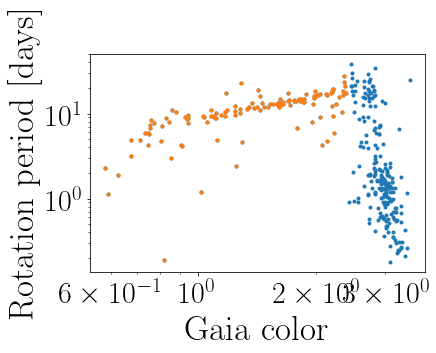

In [42]:
plt.loglog(pr.bp[pinds] - pr.rp[pinds], pr.prot[pinds], ".")
m = pr.bp.values[pinds] - pr.rp.values[pinds] < 2.4
plt.loglog(pr.bp[pinds][m] - pr.rp[pinds][m], pr.prot[pinds][m], ".")
plt.xlabel("$\mathrm{Gaia~color}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

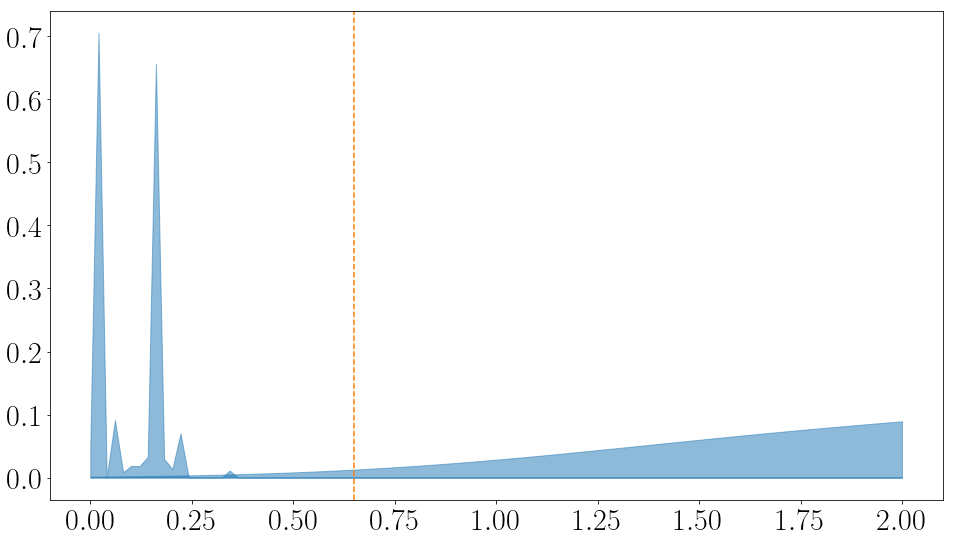

In [43]:
import scipy.stats as sps
xs = np.linspace(0, 2, 100)

plt.figure(figsize=(16, 9))
for i in range(12): #len(pmeds)):
    if m[i]:
        kernel = sps.gaussian_kde(page_samps[i])
        plt.fill_between(xs, np.zeros(100), kernel(xs), alpha=.5, color="C0")
plt.axvline(.65, color="C1", ls="--")

(0, 1)

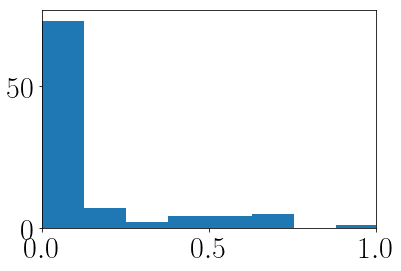

In [50]:
plt.hist(pmeds[m], 100);
plt.xlim(0, 1)

In [55]:
pinds[m]

array([  4,   9,  17,  21,  22,  30,  37,  41,  43,  44,  50,  53,  54,
        55,  57,  58,  59,  66,  67,  68,  69,  70,  72,  75,  78,  81,
        85,  88,  92, 102, 103, 111, 112, 113, 115, 116, 118, 119, 120,
       122, 130, 131, 137, 147, 148, 150, 151, 154, 157, 158, 159, 163,
       164, 165, 166, 168, 174, 175, 177, 184, 186, 192, 195, 200, 203,
       204, 206, 207, 211, 213, 215, 219, 221, 222, 224, 227, 229, 234,
       240, 241, 244, 255, 257, 258, 263, 264, 265, 266, 268, 270, 400,
       401, 412, 415, 418, 420, 422, 424, 428, 430, 433, 436, 438, 439,
       446, 450, 454, 455, 457, 461, 463, 466, 600, 605, 608, 613, 614,
       615, 618, 621, 622, 623, 635, 641, 643, 647])